In [1]:
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

from tensorflow.keras import applications

import requests
from PIL import Image
from io import BytesIO

# Data Collection

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split = ["train", "test"],
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
)

DS_NUM_OF_CLASSES = 120
DS_TEST_SIZE_50_PERCENT = int(0.5 * 8580)

ds_validation = ds_test.take(DS_TEST_SIZE_50_PERCENT)
ds_test = ds_test.skip(DS_TEST_SIZE_50_PERCENT)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWN7W2A/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWN7W2A/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

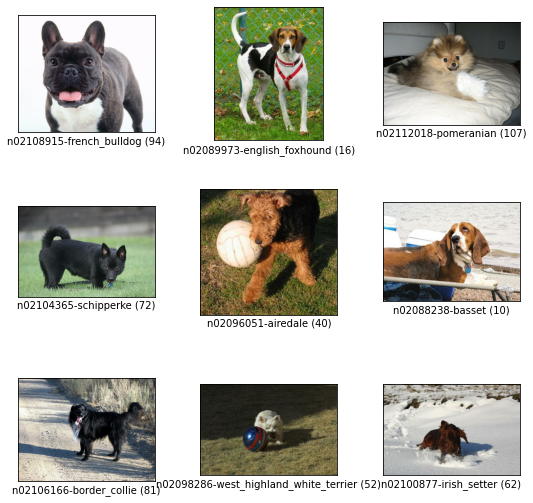

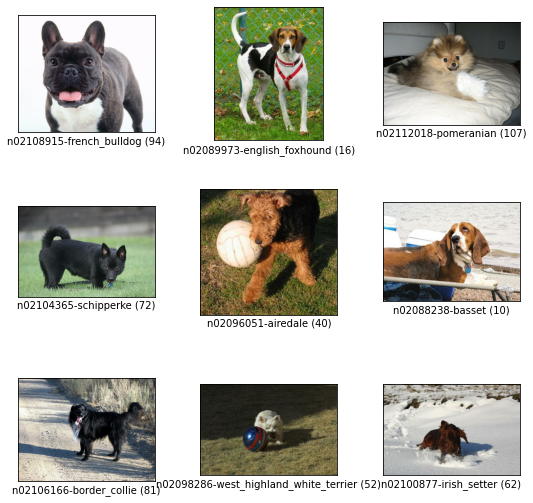

In [4]:
tfds.show_examples(ds_test, ds_info)

# Preprocessing

In [5]:
PIC_SIZE = 336
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

In [6]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32)/255.0, label

def augment_no_noise(image, label):
  image = tf.image.resize(image, (PIC_SIZE, PIC_SIZE))
  return image, label

def augment_noise(image, label):
  image = tf.image.resize(image, (PIC_SIZE, PIC_SIZE))
  image = tf.image.random_brightness(image, max_delta = 0.1)
  image = tf.image.random_contrast(image, lower = 0.1, upper = 0.2)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  return image, label

## No noise

In [7]:
ds_train_no_noise = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train_no_noise = ds_train_no_noise.map(augment_no_noise)
ds_train_no_noise = ds_train_no_noise.batch(BATCH_SIZE)

ds_validation_no_noise = ds_validation.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_validation_no_noise = ds_validation_no_noise.map(augment_no_noise)
ds_validation_no_noise = ds_validation_no_noise.batch(BATCH_SIZE)

ds_test_no_noise = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test_no_noise = ds_test_no_noise.map(augment_no_noise)
ds_test_no_noise = ds_test_no_noise.batch(BATCH_SIZE)

## Noise

In [8]:
ds_train_noise = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train_noise = ds_train_noise.map(augment_noise)
ds_train_noise = ds_train_noise.batch(BATCH_SIZE)

ds_validation_noise = ds_validation.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_validation_noise = ds_validation_noise.map(augment_noise)
ds_validation_noise = ds_validation_noise.batch(BATCH_SIZE)

ds_test_noise = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test_noise = ds_test_noise.map(augment_noise)
ds_test_noise = ds_test_noise.batch(BATCH_SIZE)

# Creating the model

In [9]:
LEARNING_RATE = 0.0001

In [10]:
def build_model(model_name="InceptionV3"):

  if model_name == "DenseNet201":
    model_part = applications.DenseNet201(include_top=False, input_shape= (PIC_SIZE, PIC_SIZE, 3), weights="imagenet")
    model_part.trainable = False
  elif model_name=="InceptionV3":
    model_part = applications.InceptionV3(include_top= False, input_shape= (PIC_SIZE, PIC_SIZE, 3), weights= 'imagenet')

  model = models.Sequential([
                             model_part,

                             layers.GlobalAveragePooling2D(),
                             layers.BatchNormalization(),

                             layers.Dropout(0.2),

                             layers.Flatten(),
                             layers.Dense(DS_NUM_OF_CLASSES, activation='softmax'),
  ], name=model_name)
  
  model.compile(
      loss=losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(LEARNING_RATE),
      metrics=['sparse_categorical_accuracy']
  )

  print(model.summary())
  return model

### DenseNet201

In [11]:
denseNet201_model_no_noise = build_model("DenseNet201")

74850304/74836368 [==============================] - 2s 0us/step
Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 10, 10, 1920)      18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                        

In [12]:
denseNet201_model_noise = build_model("DenseNet201")

Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 10, 10, 1920)      18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1920)             7680      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_1 (Dense)             (None, 120)               

### InceptionV3

In [13]:
inceptionV3_model_no_noise = build_model("InceptionV3")

87924736/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 9, 9, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_96 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                        

In [14]:
inceptionV3_model_noise = build_model("InceptionV3")

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 9, 9, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_191 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 120)               

# Training the model

In [15]:
EPOCH_NUM = 10

In [16]:
def train_model(model, noise_type="No Noise"):
  ds_train = ds_train_no_noise if noise_type == "No Noise" else ds_train_noise
  ds_validation = ds_validation_no_noise if noise_type == "No Noise" else ds_validation_noise

  log = model.fit(
      ds_train,
      epochs = EPOCH_NUM,
      validation_data = ds_validation,
  )

  train_acc = log.history['sparse_categorical_accuracy'][-1] * 100
  val_acc = log.history['val_sparse_categorical_accuracy'][-1] * 100

  print("Traning Accuracy = %.2f%%" % train_acc)
  print("Validation Accuracy = %.2f%%" % val_acc)

  pl.plot(log.history['sparse_categorical_accuracy'])
  pl.plot(log.history['val_sparse_categorical_accuracy'])
  pl.legend(['Training Accuracy', 'Validation Accuracy'])
  pl.grid(True)
  pl.title("Model Accuracy")
  pl.show()

  pl.plot(log.history['loss'])
  pl.plot(log.history['val_loss'])
  pl.legend(['Training Loss', 'Validation Loss'])
  pl.grid(True)
  pl.title("Model Loss")
  pl.show()

## No Noise

### DenseNet201

Epoch 1/10
188/188 [==============================] - 376s 2s/step - loss: 4.3763 - sparse_categorical_accuracy: 0.0773 - val_loss: 3.7159 - val_sparse_categorical_accuracy: 0.2548
Epoch 2/10
188/188 [==============================] - 334s 2s/step - loss: 2.9484 - sparse_categorical_accuracy: 0.3413 - val_loss: 2.5019 - val_sparse_categorical_accuracy: 0.5254
Epoch 3/10
188/188 [==============================] - 333s 2s/step - loss: 2.0677 - sparse_categorical_accuracy: 0.5598 - val_loss: 1.7717 - val_sparse_categorical_accuracy: 0.6618
Epoch 4/10
188/188 [==============================] - 333s 2s/step - loss: 1.5329 - sparse_categorical_accuracy: 0.6834 - val_loss: 1.3677 - val_sparse_categorical_accuracy: 0.7240
Epoch 5/10
188/188 [==============================] - 333s 2s/step - loss: 1.2082 - sparse_categorical_accuracy: 0.7450 - val_loss: 1.1305 - val_sparse_categorical_accuracy: 0.7618
Epoch 6/10
188/188 [==============================] - 333s 2s/step - loss: 0.9949 - sparse_cate

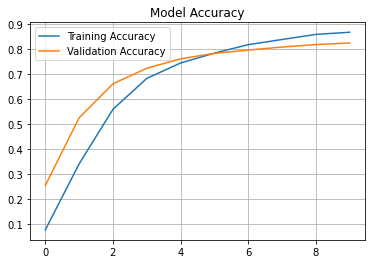

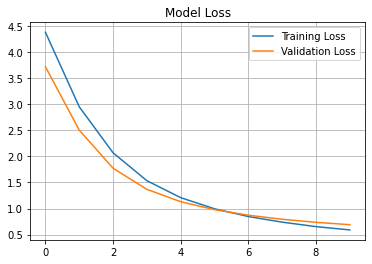

In [17]:
train_model(denseNet201_model_no_noise, "No Noise")

### InceptionV3

Epoch 1/10
188/188 [==============================] - 517s 3s/step - loss: 1.2273 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.8375
Epoch 2/10
188/188 [==============================] - 485s 3s/step - loss: 0.1824 - sparse_categorical_accuracy: 0.9453 - val_loss: 0.5685 - val_sparse_categorical_accuracy: 0.8287
Epoch 3/10
188/188 [==============================] - 486s 3s/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.4564 - val_sparse_categorical_accuracy: 0.8650
Epoch 4/10
188/188 [==============================] - 524s 3s/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.4128 - val_sparse_categorical_accuracy: 0.8786
Epoch 5/10
188/188 [==============================] - 486s 3s/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.4113 - val_sparse_categorical_accuracy: 0.8800
Epoch 6/10
188/188 [==============================] - 486s 3s/step - loss: 0.0059 - sparse_cate

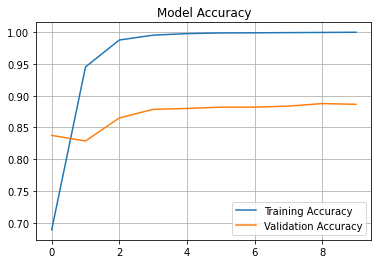

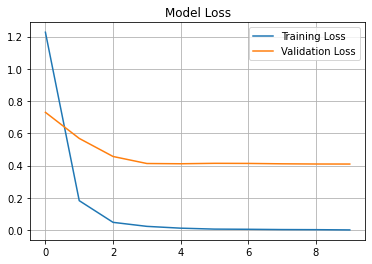

In [18]:
train_model(inceptionV3_model_no_noise, "No Noise")

## Noise

### DenseNet201

Epoch 1/10
188/188 [==============================] - 402s 2s/step - loss: 4.9987 - sparse_categorical_accuracy: 0.0183 - val_loss: 4.6225 - val_sparse_categorical_accuracy: 0.0338
Epoch 2/10
188/188 [==============================] - 332s 2s/step - loss: 4.5220 - sparse_categorical_accuracy: 0.0498 - val_loss: 4.3197 - val_sparse_categorical_accuracy: 0.0718
Epoch 3/10
188/188 [==============================] - 387s 2s/step - loss: 4.1815 - sparse_categorical_accuracy: 0.0864 - val_loss: 4.0446 - val_sparse_categorical_accuracy: 0.1089
Epoch 4/10
188/188 [==============================] - 332s 2s/step - loss: 3.9208 - sparse_categorical_accuracy: 0.1288 - val_loss: 3.8348 - val_sparse_categorical_accuracy: 0.1490
Epoch 5/10
188/188 [==============================] - 332s 2s/step - loss: 3.7231 - sparse_categorical_accuracy: 0.1604 - val_loss: 3.6476 - val_sparse_categorical_accuracy: 0.1727
Epoch 6/10
188/188 [==============================] - 333s 2s/step - loss: 3.5616 - sparse_cate

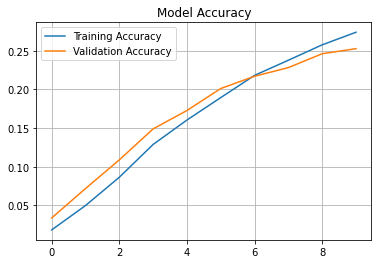

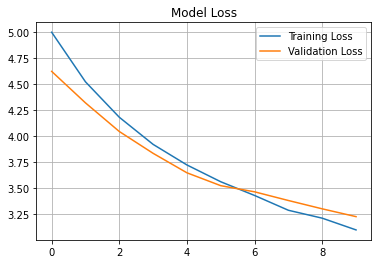

In [19]:
train_model(denseNet201_model_noise, "Noise")

### InceptionV3

Epoch 1/10
188/188 [==============================] - 496s 3s/step - loss: 2.1225 - sparse_categorical_accuracy: 0.4848 - val_loss: 1.5167 - val_sparse_categorical_accuracy: 0.6172
Epoch 2/10
188/188 [==============================] - 485s 3s/step - loss: 0.8179 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.7198
Epoch 3/10
188/188 [==============================] - 485s 3s/step - loss: 0.4894 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.9370 - val_sparse_categorical_accuracy: 0.7266
Epoch 4/10
188/188 [==============================] - 486s 3s/step - loss: 0.3215 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.7408
Epoch 5/10
188/188 [==============================] - 486s 3s/step - loss: 0.2122 - sparse_categorical_accuracy: 0.9367 - val_loss: 0.9415 - val_sparse_categorical_accuracy: 0.7326
Epoch 6/10
188/188 [==============================] - 486s 3s/step - loss: 0.1460 - sparse_cate

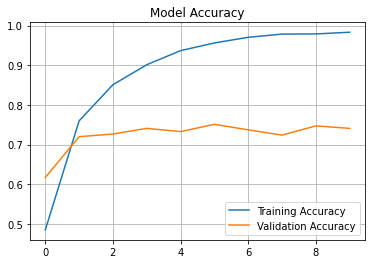

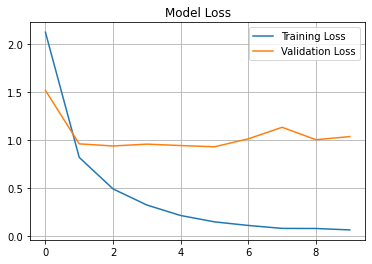

In [20]:
train_model(inceptionV3_model_noise, "Noise")

# Testing the model

In [21]:
label_map = [
             "Chihuahua",
             "Japanese Spaniel",
             "Maltese Dog",
             "Pekinese",
             "Shih-Tzu",

             "Blenheim Spaniel",
             "Papillion",
             "Toy Terrier",
             "Rhodesian Ridgeback",
             "Afghan Hound",
]

url_map = [
           "http://www.dog-learn.com/dog-breeds/chihuahua/images/chihuahua-u1.jpg",
           "https://www.dogproductpicker.com/wp-content/uploads/2019/06/Japanese-Chin-Dog-Breed-Information-All-You-Need-To-Know.jpg",
           "http://2.bp.blogspot.com/-6sxj3DSKTrY/UHQoywaHI9I/AAAAAAAAAeI/KlK2pqxBrLk/s1600/Maltese_Puppy.jpg",
           "https://www.bil-jac.com/media/yhpn5zk4/pekingese-612830804.jpg",
           "https://cdn.fotofits.com/petzlover/gallery/img/l/shih-tzu-482537.jpeg",

           "https://www.warrenphotographic.co.uk/photography/bigs/18764-Blenheim-Cavalier-King-Charles-Spaniel-pups-white-background.jpg",
           "https://i.pinimg.com/originals/66/7e/c5/667ec51548e094fa288212cca22211ba.jpg",
           "http://animalsbreeds.com/wp-content/uploads/2014/12/Toy-Manchester-Terrier-6.jpg",
           "https://breedadvisor.com/wp-content/uploads/2020/03/rhodesian-ridgeback-gallery.gif",
           "https://fishsubsidy.org/wp-content/uploads/2020/01/afghan-hound2.jpg",
]

In [22]:
url_predict = []
url_images = []

for url in url_map:
  response = requests.get(url)
  img = np.array(Image.open(BytesIO(response.content)).convert('RGB').resize((PIC_SIZE, PIC_SIZE)))
  url_images.append(img)

  img = img / 255.0
  img = np.expand_dims(img, axis = 0)
  url_predict.append(img)

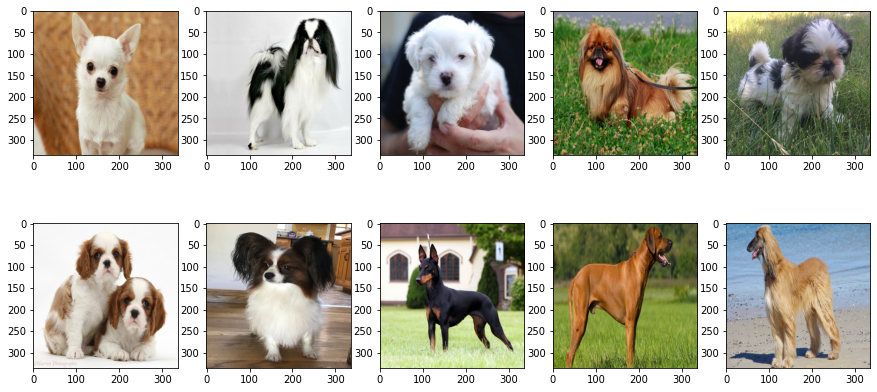

In [23]:
fig = pl.figure(figsize=(15, 15))
columns = 5
rows = 4
for i in range(len(url_images)):
    fig.add_subplot(rows, columns, i + 1)
    pl.imshow(url_images[i])
pl.show()


In [24]:
def test_model(model, noise_type="No Noise"):
  ds_test = ds_test_no_noise if noise_type == "No Noise" else ds_test_noise

  log = model.evaluate(ds_test)

  test_acc = log[-1] * 100
  print("Testing Accuracy = %.2f%%" % test_acc)

  for i in range(len(url_predict)):
    pl.imshow(url_images[i])
    pl.show()

    guess_arr = model.predict(url_predict[i])
    guess_index = np.argmax(guess_arr)

    guess_label = "ERROR, OUT OF BOUNDS"
    if guess_index < 10:
      guess_label = label_map[guess_index]

    print("Guess Index:", guess_index)
    print("Guess Label:", guess_label)
    print("Guess Verdict:", "CORRECT" if guess_index == i else "WRONG")

## No Noise

### DenseNet201

68/68 [==============================] - 92s 1s/step - loss: 0.6852 - sparse_categorical_accuracy: 0.8273
Testing Accuracy = 82.73%


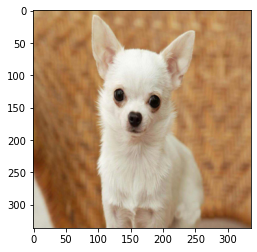

Guess Index: 0
Guess Label: Chihuahua
Guess Verdict: CORRECT


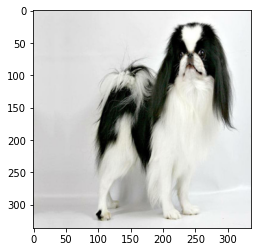

Guess Index: 1
Guess Label: Japanese Spaniel
Guess Verdict: CORRECT


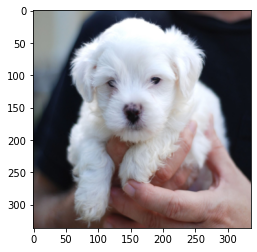

Guess Index: 2
Guess Label: Maltese Dog
Guess Verdict: CORRECT


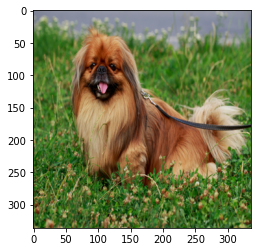

Guess Index: 3
Guess Label: Pekinese
Guess Verdict: CORRECT


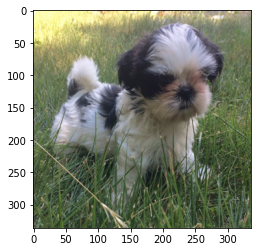

Guess Index: 4
Guess Label: Shih-Tzu
Guess Verdict: CORRECT


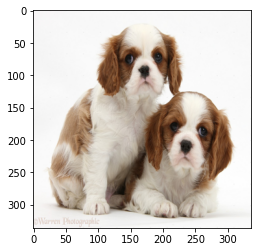

Guess Index: 5
Guess Label: Blenheim Spaniel
Guess Verdict: CORRECT


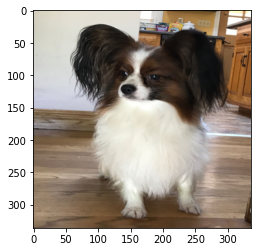

Guess Index: 6
Guess Label: Papillion
Guess Verdict: CORRECT


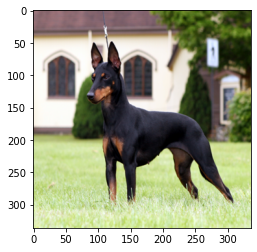

Guess Index: 85
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


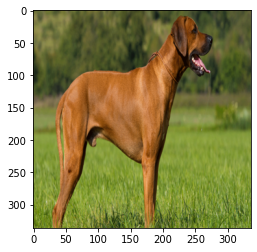

Guess Index: 8
Guess Label: Rhodesian Ridgeback
Guess Verdict: CORRECT


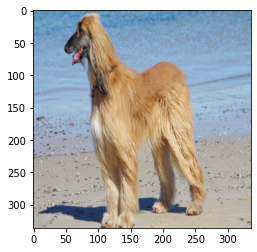

Guess Index: 9
Guess Label: Afghan Hound
Guess Verdict: CORRECT


In [25]:
test_model(denseNet201_model_no_noise, "No Noise")

### InceptionV3

68/68 [==============================] - 49s 649ms/step - loss: 0.4652 - sparse_categorical_accuracy: 0.8739
Testing Accuracy = 87.39%


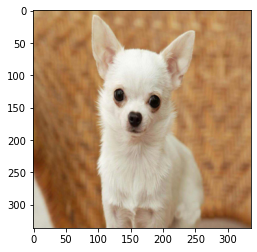

Guess Index: 0
Guess Label: Chihuahua
Guess Verdict: CORRECT


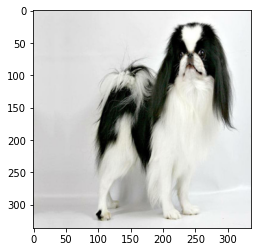

Guess Index: 1
Guess Label: Japanese Spaniel
Guess Verdict: CORRECT


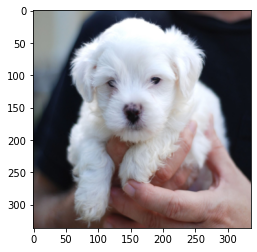

Guess Index: 2
Guess Label: Maltese Dog
Guess Verdict: CORRECT


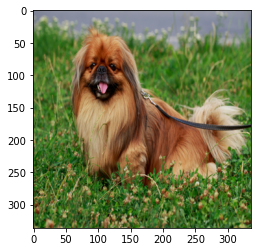

Guess Index: 3
Guess Label: Pekinese
Guess Verdict: CORRECT


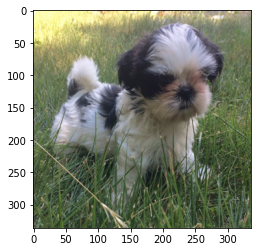

Guess Index: 4
Guess Label: Shih-Tzu
Guess Verdict: CORRECT


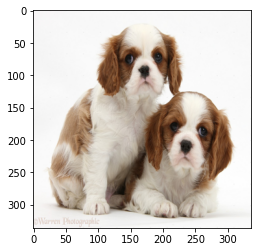

Guess Index: 5
Guess Label: Blenheim Spaniel
Guess Verdict: CORRECT


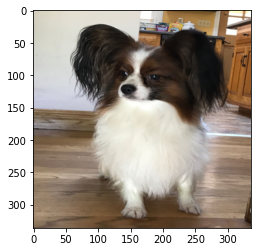

Guess Index: 6
Guess Label: Papillion
Guess Verdict: CORRECT


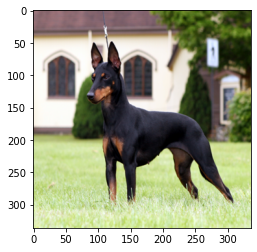

Guess Index: 85
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


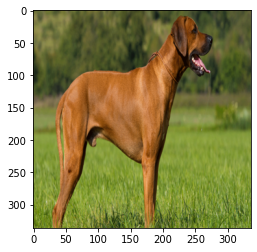

Guess Index: 8
Guess Label: Rhodesian Ridgeback
Guess Verdict: CORRECT


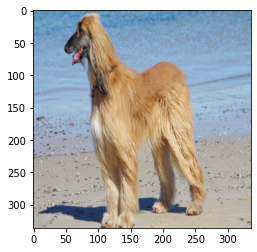

Guess Index: 9
Guess Label: Afghan Hound
Guess Verdict: CORRECT


In [26]:
test_model(inceptionV3_model_no_noise, "No Noise")

## Noise

### DenseNet201

68/68 [==============================] - 92s 1s/step - loss: 3.2074 - sparse_categorical_accuracy: 0.2592
Testing Accuracy = 25.92%


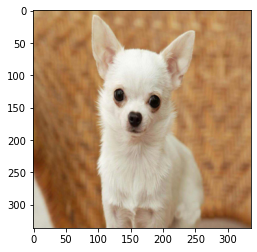

Guess Index: 0
Guess Label: Chihuahua
Guess Verdict: CORRECT


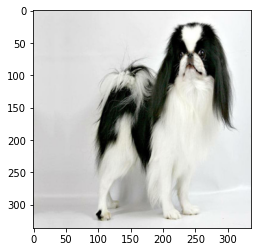

Guess Index: 1
Guess Label: Japanese Spaniel
Guess Verdict: CORRECT


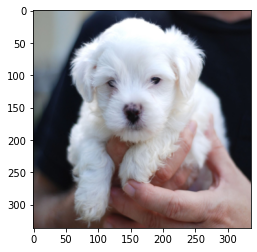

Guess Index: 36
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


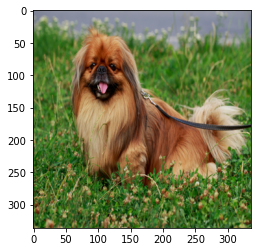

Guess Index: 69
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


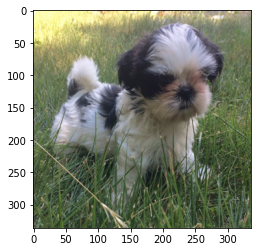

Guess Index: 4
Guess Label: Shih-Tzu
Guess Verdict: CORRECT


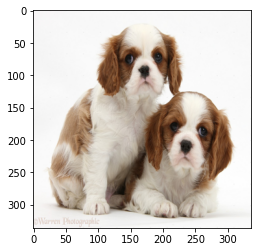

Guess Index: 5
Guess Label: Blenheim Spaniel
Guess Verdict: CORRECT


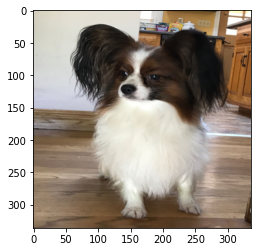

Guess Index: 6
Guess Label: Papillion
Guess Verdict: CORRECT


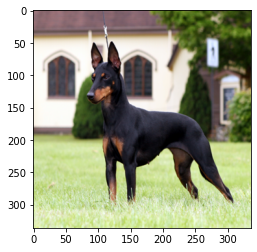

Guess Index: 85
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


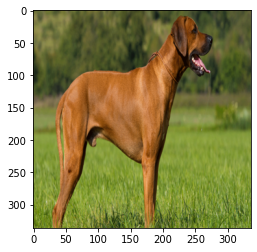

Guess Index: 17
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


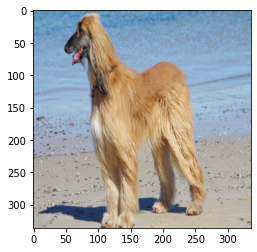

Guess Index: 9
Guess Label: Afghan Hound
Guess Verdict: CORRECT


In [27]:
test_model(denseNet201_model_noise, "Noise")

### InceptionV3

68/68 [==============================] - 49s 650ms/step - loss: 1.0146 - sparse_categorical_accuracy: 0.7571
Testing Accuracy = 75.71%


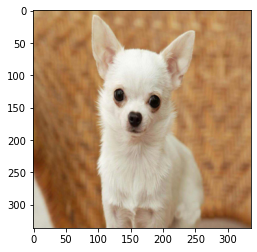

Guess Index: 0
Guess Label: Chihuahua
Guess Verdict: CORRECT


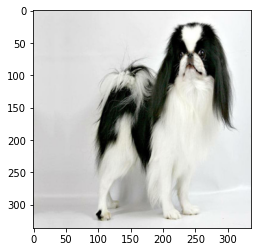

Guess Index: 1
Guess Label: Japanese Spaniel
Guess Verdict: CORRECT


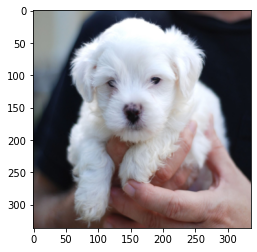

Guess Index: 2
Guess Label: Maltese Dog
Guess Verdict: CORRECT


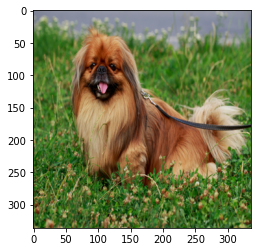

Guess Index: 3
Guess Label: Pekinese
Guess Verdict: CORRECT


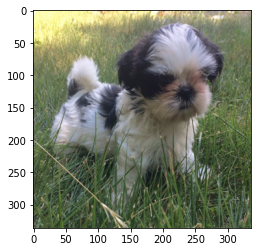

Guess Index: 4
Guess Label: Shih-Tzu
Guess Verdict: CORRECT


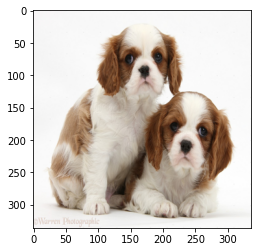

Guess Index: 5
Guess Label: Blenheim Spaniel
Guess Verdict: CORRECT


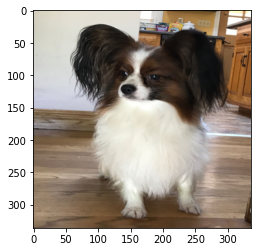

Guess Index: 6
Guess Label: Papillion
Guess Verdict: CORRECT


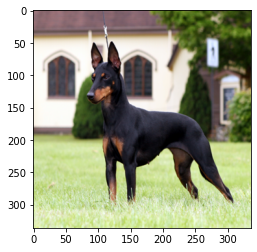

Guess Index: 85
Guess Label: ERROR, OUT OF BOUNDS
Guess Verdict: WRONG


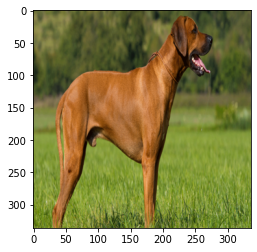

Guess Index: 8
Guess Label: Rhodesian Ridgeback
Guess Verdict: CORRECT


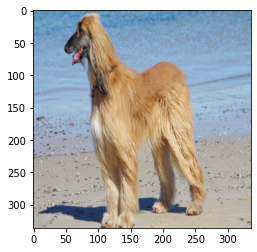

Guess Index: 9
Guess Label: Afghan Hound
Guess Verdict: CORRECT


In [28]:
test_model(inceptionV3_model_noise, "Noise")